# Multiple Sclerosis

This data set was generated by [Falcão et al, 2018](https://www.nature.com/articles/s41591-018-0236-y) containing 2,208 mouse cells probed by SMART-seq2 with half experimental autoimmune encephalomyelitis (EAE) cells (in mimicing multiple scleorsis) and half control cells.

Here, we will illustrate how BRIE2 can be used to effectively detect differential splicing events between EAE and control cells, and using splicing ratio to predict cell type and disease conditions.

We have pre-processed the data with these [BRIE2 scripts](https://github.com/huangyh09/brie-tutorials/blob/main/msEAE/run_brie2.sh) with ``brie-count`` and ``brie-quant``. You can download the [pre-computed data](https://sourceforge.net/projects/brie-rna/files/examples/msEAE/), e.g., by using the following command line and unzip it into the `./data` folder for running this notebook.

```bash
wget http://ufpr.dl.sourceforge.net/project/brie-rna/examples/msEAE/brie2_msEAE.zip
unzip -j brie2_msEAE.zip -d ./data
```

## Load Packages

In [1]:
import umap

In [2]:
import os
import brie
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

print(brie.__version__)

2.0.5


In [3]:
# define the path you store the example data
# dat_dir = "./data"
dat_dir = "/storage/yhhuang/research/brie2/releaseDat/msEAE/"

## BRIE2 option 1: differential splicing events

Detecting differential splicing event by regressing on the EAE state with considering the strain covariate.

The command line is available at [run_brie2.sh](https://github.com/huangyh09/brie-tutorials/blob/main/msEAE/run_brie2.sh).
Here is an example of [design matrix](https://github.com/huangyh09/brie-tutorials/blob/main/msEAE/data/cell_anno.tsv) besides the intercept and `isEAE` as the only testing variable.
```
samID   isEAE   isCD1
SRR7102862      0       1
SRR7103631      1       0
SRR7104046      1       1
SRR7105069      0       0
```

Besides the big .h5ad file, you can use the detected splicing events directely from [brie_quant_cell.brie_ident.tsv](https://github.com/huangyh09/brie-tutorials/blob/main/msEAE/data/brie_quant_cell.brie_ident.tsv).
However, if you want get the quantify `Psi` for downstream analysis, e.g., option2 below, you need load the `adata.layers['Psi']`, and `adata.layers['Psi_95CI']`.

In [4]:
adata = sc.read_h5ad(dat_dir + "/brie_quant_cell.h5ad")
adata

AnnData object with n_obs × n_vars = 2208 × 3780
    obs: 'samID', 'samCOUNT'
    var: 'GeneID', 'GeneName', 'TranLens', 'TranIDs', 'n_counts', 'n_counts_uniq', 'loss_gene'
    uns: 'Xc_ids', 'brie_losses', 'brie_param', 'brie_version'
    obsm: 'Xc'
    varm: 'ELBO_gain', 'cell_coeff', 'effLen', 'fdr', 'intercept', 'p_ambiguous', 'pval', 'sigma'
    layers: 'Psi', 'Psi_95CI', 'Z_std', 'ambiguous', 'isoform1', 'isoform2', 'poorQual'

In [5]:
adata.uns['brie_param']

{'LRT_index': array([0]),
 'base_mode': 'full',
 'intercept_mode': 'gene',
 'layer_keys': array(['isoform1', 'isoform2', 'ambiguous'], dtype=object),
 'pseudo_count': 0.01}

Change gene index from Ensemebl id to gene name

In [6]:
adata.var['old_index'] = adata.var.index
new_index = [adata.var.GeneName[i] + adata.var.GeneID[i][18:] for i in range(adata.shape[1])]
adata.var.index = new_index

Add the cell annotations from input covariates

In [7]:
adata.obs['MS'] = ['EAE' if x else 'Ctrl' for x in adata.obsm['Xc'][:, 0]]
adata.obs['isCD1'] = ['CD1_%d' %x for x in adata.obsm['Xc'][:, 1]]

#### Volcano plot
Here, BRIE2 detects the differential splicing events between EAE and control. Cell_coeff means the effect size on logit(Psi). Positive value means higher Psi in isEAE.

Text(0.5, 1.0, 'MS differential splicing')

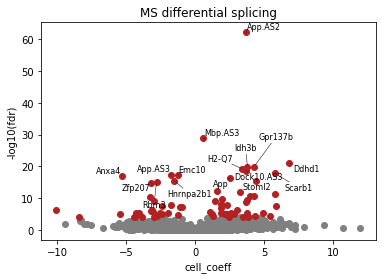

In [8]:
## volcano plot for differential splicing events

brie.pl.volcano(adata, y='fdr', n_anno=16, adjust=True)
plt.title("MS differential splicing")

In [9]:
DSEs = adata.var.index[adata.varm['fdr'][:, 0] < 0.05]
len(DSEs), len(np.unique([x.split('.')[0] for x in DSEs])), adata.shape

(368, 348, (2208, 3780))

In [10]:
adata.uns['Xc_ids']

array(['isEAE', 'isCD1'], dtype=object)

#### Visualize raw counts for DSEs

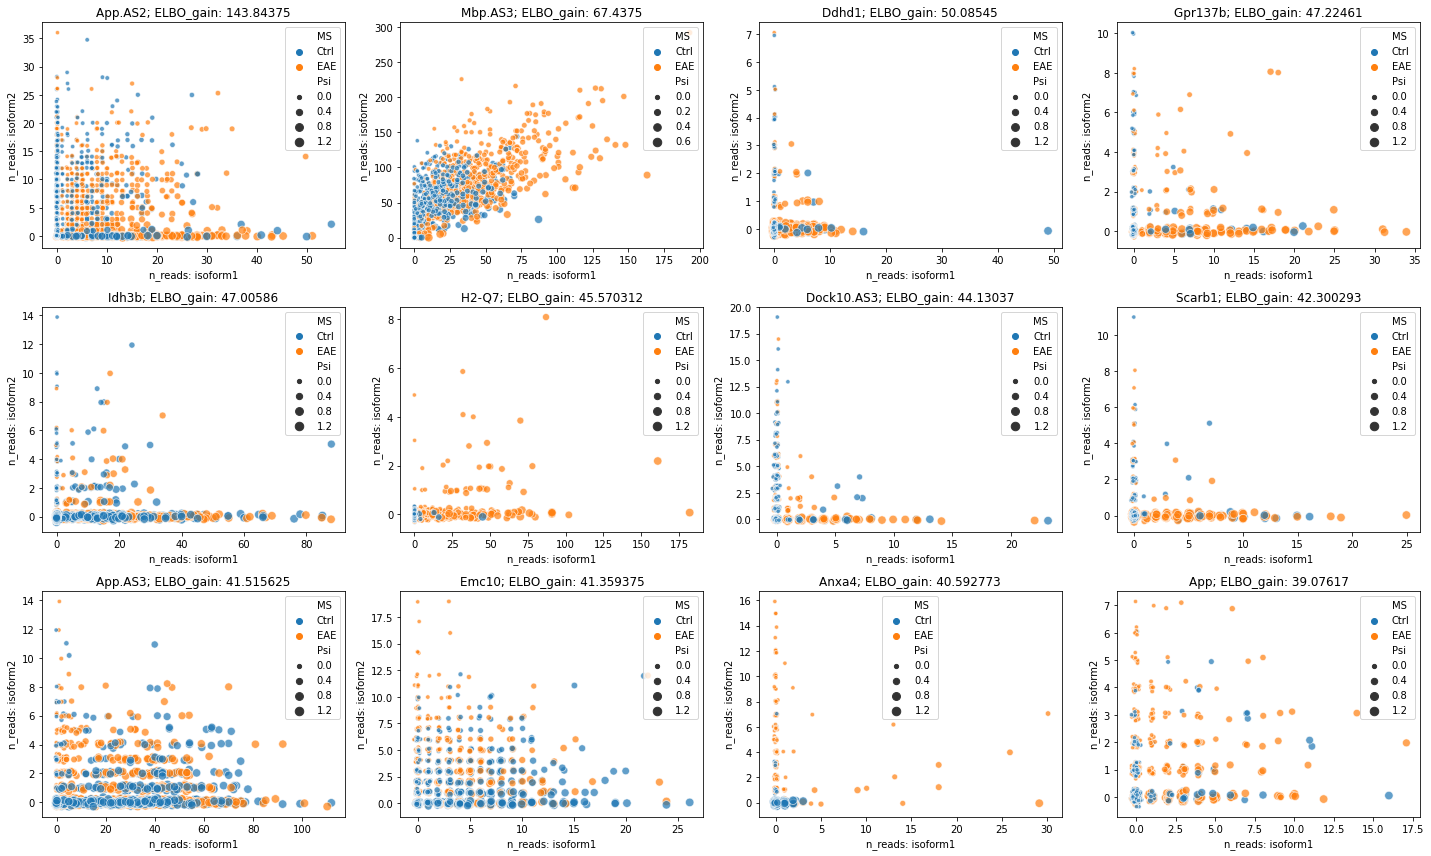

In [11]:
rank_idx = np.argsort(adata.varm['ELBO_gain'][:, 0])[::-1]

fig = plt.figure(figsize=(20, 12))
brie.pl.counts(adata, genes=list(adata.var.index[rank_idx[:12]]), 
               color='MS', add_val='ELBO_gain', nrow=3, alpha=0.7)
# fig.savefig(dat_dir + '../../figures/fig_s8_counts.png', dpi=300, bbox_inches='tight')
plt.show()

##### Changed ratio between ambiguous reads
Some differential splicing events having changed ratio on ambigous reads and isoform specific reads

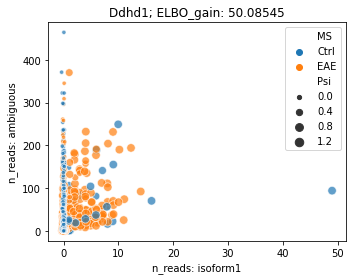

In [12]:
### Differential splicing shown by isoform1 and ambiguous reads

fig = plt.figure(figsize=(5, 4))
brie.pl.counts(adata, genes='Ddhd1', 
               color='MS', add_val='ELBO_gain', 
               layers=['isoform1', 'ambiguous'],
               nrow=1, alpha=0.7)
plt.show()

## BRIE2 option 2: splicing quantification and usage

If you aim to use splicing isoform proportions as phenotypes for downstream analysis, e.g., to identify cell types, or study its disease contribution, we suggest not including the cell feature as covariate when quantifying `Psi` to avoid circular analysis.

Instead you could use gene level features, e.g., sequence features we introduced in [BRIE1](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-017-1248-5), or you can use an aggregated value from all cells as an informative prior. Similar as BRIE1, this prior is learned from the data and has a logit-normal distribution, so the information prior usually won't be too strong.

In general, we recommend using the aggregation of cells as the prior thanks to its simplicity if it does not violate your biological hypothesis.

### Load data and basic preprocessing

In [13]:
adata_aggr = sc.read_h5ad(dat_dir + "/brie_quant_aggr.h5ad")

adata_aggr

AnnData object with n_obs × n_vars = 2208 × 3780
    obs: 'samID', 'samCOUNT'
    var: 'GeneID', 'GeneName', 'TranLens', 'TranIDs', 'n_counts', 'n_counts_uniq'
    uns: 'brie_losses'
    obsm: 'Xc'
    varm: 'cell_coeff', 'effLen', 'intercept', 'p_ambiguous', 'sigma'
    layers: 'Psi', 'Psi_95CI', 'Z_std', 'ambiguous', 'isoform1', 'isoform2', 'poorQual'

In [14]:
## change gene index
print(np.mean(adata.var['old_index'] == adata_aggr.var.index))

adata_aggr.var.index = adata.var.index

1.0


#### Add meta data and gene-level annotation
Cell annotations and UMAP from gene-level expression. You can add any additional annotation.

In [15]:
print(np.mean(adata.obs.index == adata_aggr.obs.index))
adata_aggr.obs['MS'] = adata.obs['MS'].copy()
adata_aggr.obs['isCD1'] = adata.obs['isCD1'].copy()

1.0


In [16]:
dat_umap = np.genfromtxt(dat_dir + '/cell_X_umap.tsv', dtype='str', delimiter='\t')

mm = brie.match(adata_aggr.obs.index, dat_umap[:, 0])
idx = mm[mm != None].astype(int)

adata_aggr = adata_aggr[mm != None, :]
adata_aggr.obsm['X_GEX_UMAP'] = dat_umap[idx, 1:3].astype(float)
adata_aggr.obs['cluster'] = dat_umap[idx, 3]
adata_aggr.obs['combine'] = [adata_aggr.obs['cluster'][i] + '-' + adata_aggr.obs['MS'][i] 
                            for i in range(adata_aggr.shape[0])]

In [17]:
adata_aggr

AnnData object with n_obs × n_vars = 1882 × 3780
    obs: 'samID', 'samCOUNT', 'MS', 'isCD1', 'cluster', 'combine'
    var: 'GeneID', 'GeneName', 'TranLens', 'TranIDs', 'n_counts', 'n_counts_uniq'
    uns: 'brie_losses'
    obsm: 'Xc', 'X_GEX_UMAP'
    varm: 'cell_coeff', 'effLen', 'intercept', 'p_ambiguous', 'sigma'
    layers: 'Psi', 'Psi_95CI', 'Z_std', 'ambiguous', 'isoform1', 'isoform2', 'poorQual'

#### Cell filtering

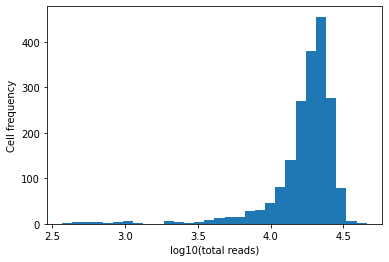

In [18]:
plt.hist(np.log10(adata_aggr.X.sum(1)[:, 0] + 1), bins=30)
plt.xlabel("log10(total reads)")
plt.ylabel("Cell frequency")
plt.show()

In [19]:
# min_reads = 15000
min_reads = 3000

adata_aggr = adata_aggr[adata_aggr.X.sum(axis=1) > min_reads, :]
adata = adata[adata_aggr.obs.index, :]

## Visualizing splicing phenotypes in Gene expression UMAP

/home/yuanhua/.conda/envs/TFProb/lib/python3.7/site-packages/anndata/_core/anndata.py:1210: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'MS' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'isCD1' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cluster' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'combine' as categorical


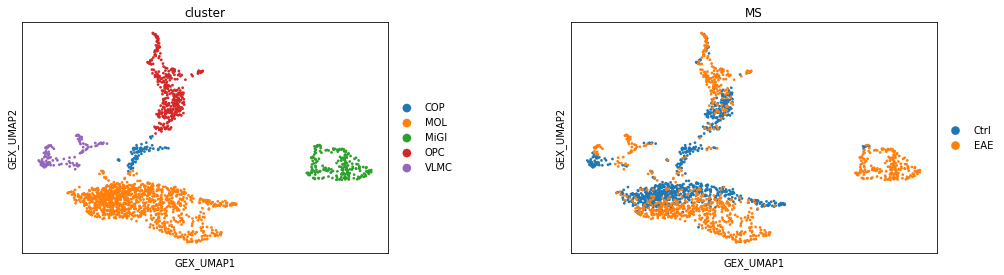

In [20]:
sc.pl.scatter(adata_aggr, basis='GEX_UMAP', color=['cluster', 'MS'], size=30)

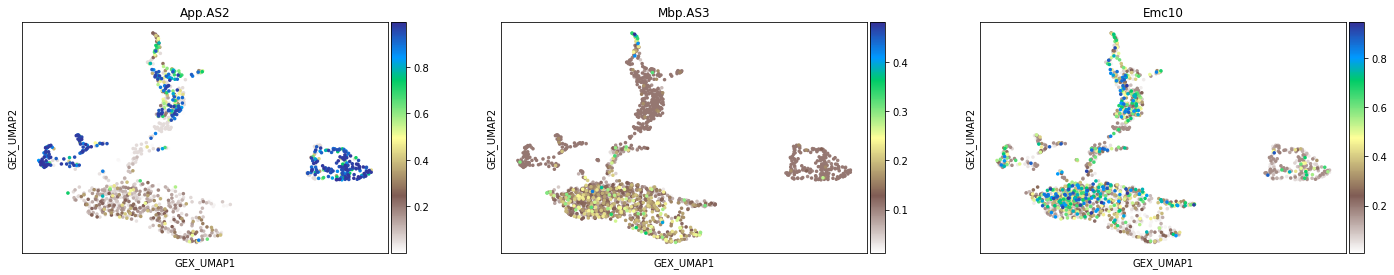

In [21]:
sc.pl.scatter(adata_aggr, basis='GEX_UMAP', layers='Psi',
              color=['App.AS2', 'Mbp.AS3', 'Emc10'], 
              size=50, color_map='terrain_r') #'terrain_r'

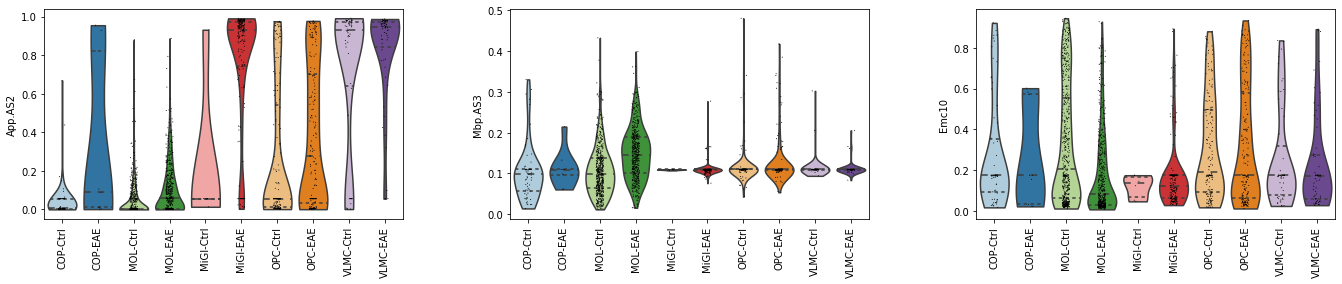

In [22]:
import seaborn as sns

sc.pl.violin(adata_aggr, ['App.AS2', 'Mbp.AS3', 'Emc10'], 
             layer='Psi', groupby='combine', rotation=90, 
             inner='quartile', palette=sns.color_palette("Paired"))

## Dimension reduction on Psi

For downstream analysis, we only using splicing events that have been detected as differential splicing events. As mentioned earlier, the `Psi` is re-quantified by not using the cell-level information.

In [23]:
idx = list(adata.varm['fdr'][:, 0] < 0.05)
adata_psi = adata_aggr[:, idx]

adata_psi.layers['X'] = adata_psi.X.astype(np.float64)
adata_psi.X = adata_psi.layers['Psi']
adata_psi.shape

(1845, 368)

In [24]:
sc.tl.pca(adata_psi, svd_solver='arpack')

In [25]:
adata_psi.obs['Psi_PC1'] = adata_psi.obsm['X_pca'][:, 0]
adata_psi.obs['Psi_PC2'] = adata_psi.obsm['X_pca'][:, 1]
adata_psi.obs['Psi_PC3'] = adata_psi.obsm['X_pca'][:, 2]

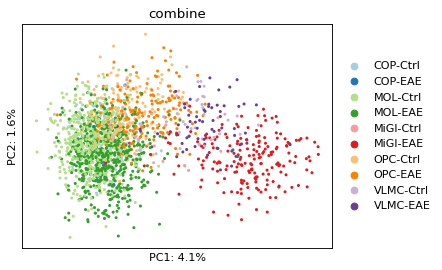

In [26]:
fig = plt.figure(figsize=(5, 3.7), dpi=80)
ax = plt.subplot(1, 1, 1)
sc.pl.pca(adata_psi, color='combine', size=30, show=False, ax=ax, 
          palette=sns.color_palette("Paired"))
plt.xlabel("PC1: %.1f%%" %(adata_psi.uns['pca']['variance_ratio'][0] * 100))
plt.ylabel("PC2: %.1f%%" %(adata_psi.uns['pca']['variance_ratio'][1] * 100))
# plt.legend(loc=1)
plt.show()

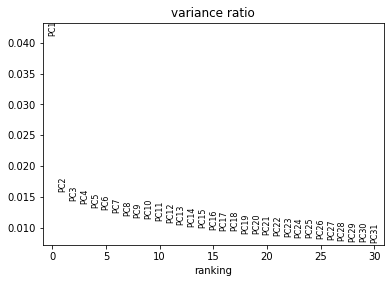

In [27]:
sc.pl.pca_variance_ratio(adata_psi)

In [28]:
sc.pp.neighbors(adata_psi, n_neighbors=10, n_pcs=20, method='umap')
sc.tl.umap(adata_psi)

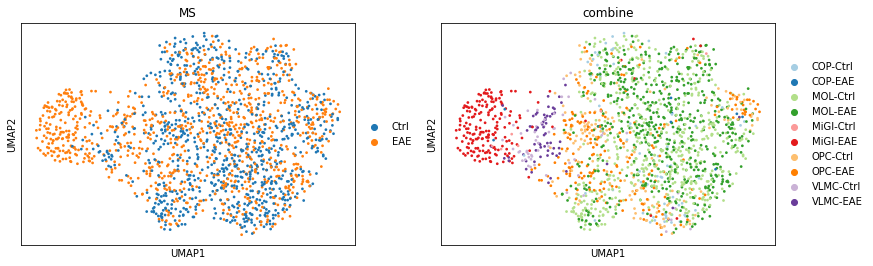

In [29]:
sc.pl.umap(adata_psi, color=['MS', 'combine'], size=30)

#### Visualise the Psi value on Psi-based UMAP

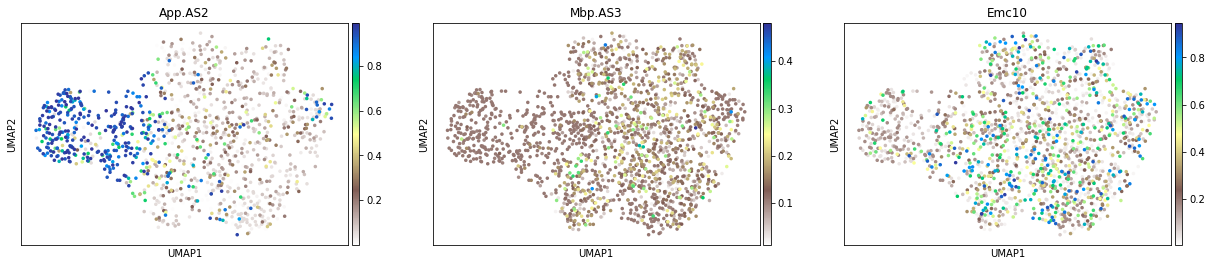

In [30]:
sc.pl.umap(adata_psi, color=['App.AS2', 'Mbp.AS3', 'Emc10'], size=50, cmap='terrain_r')

##### Only for the cells with confident Psi estimate

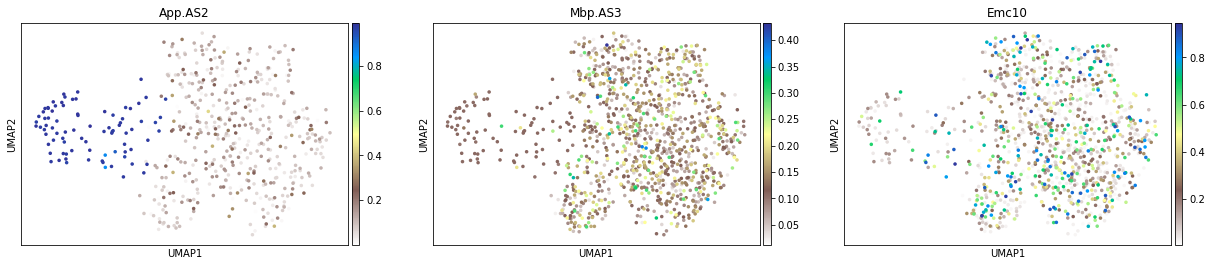

In [31]:
adata_tmp = adata_psi[adata_psi[:, 'App.AS2'].layers['Psi_95CI'] < 0.3, :]
adata_tmp.X = adata_tmp.layers['Psi']
sc.pl.umap(adata_tmp, color=['App.AS2', 'Mbp.AS3', 'Emc10'], size=50, cmap='terrain_r')

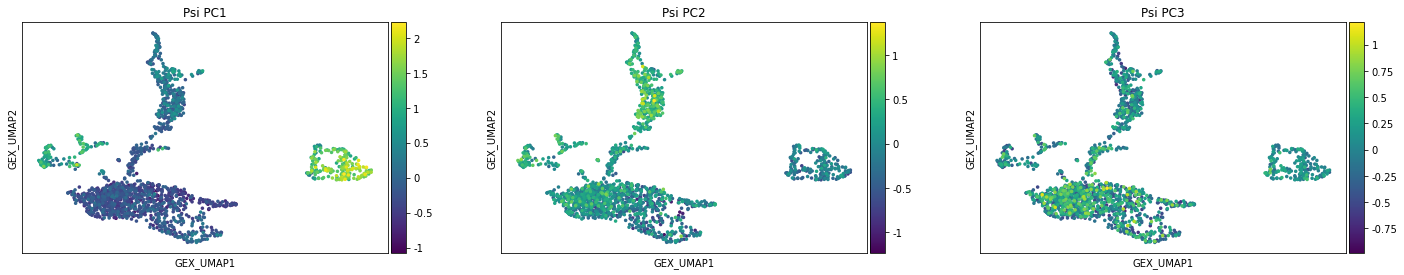

In [32]:
sc.pl.scatter(adata_psi, basis='GEX_UMAP', color=['Psi_PC1', 'Psi_PC2', 'Psi_PC3'], size=50)

### Prediction of cell type

One potential usage of the quantified `Psi` is to identify cell types. Instead of using them to cluster cells, here we show that by using the `Psi` (and their principle compoments), the annotated cell types from gene expression can be accurately predicted. 

In [33]:
np.random.seed = 1

In [34]:
_val, _idx = np.unique(pd.factorize(adata_psi.obs['cluster'])[0], return_index=True)
print(_val, _idx)
print(adata_psi.obs['cluster'][_idx])

[0 1 2 3 4] [  0   8  54  92 890]
SRR7102862     OPC
SRR7102870     MOL
SRR7102925     COP
SRR7102967    VLMC
SRR7103970    MiGl
Name: cluster, dtype: category
Categories (5, object): [COP, MOL, MiGl, OPC, VLMC]


In [35]:
import scipy.stats as st
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from hilearn import ROC_plot, CrossValidation

LogisticRegression = linear_model.LogisticRegression()
RF_class = RandomForestClassifier(n_estimators=100, n_jobs=-1)

X1 = adata_psi.obsm['X_pca'][:, :20]
Y1 = pd.factorize(adata_psi.obs['cluster'])[0]

CV = CrossValidation(X1, Y1)
# Y1_pre, Y1_score = CV.cv_classification(model=RF_class, folds=10)
Y2_pre, Y2_score = CV.cv_classification(model=LogisticRegression, folds=10)

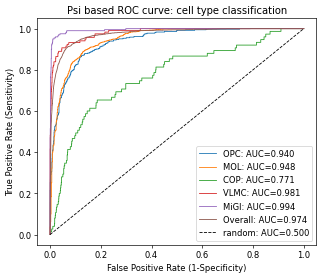

In [36]:
fig = plt.figure(figsize=(6, 5), dpi=60)
# ROC_plot(Y1, Y1_score[:,1], label="Random Forest", base_line=False)
# ROC_plot(Y1, Y2_score[:,1], label="Logistic Regress")

for i in range(5):
    ROC_plot(Y1 == i, Y2_score[:,i], 
             label=adata_psi.obs['cluster'][_idx[i]], 
             base_line=False)
ROC_plot(np.concatenate([Y1 == i for i in range(5)]),
         Y2_score.T.reshape(-1), label='Overall')

plt.title("Psi based ROC curve: cell type classification")

# fig.savefig(dat_dir + '../../figures/fig_s7_classification.pdf', dpi=300, bbox_inches='tight')
plt.show()

### Prediction of MS state

Besides using Psi to predict the cell types, a more interesting task is to predict if a cell is in disease state (i.e., EAE state). Though by only using the `Psi`, it achieves moderate performance but clearly improves the prediction together with the gene expression.

In [37]:
dat_GEX_pc = np.genfromtxt(dat_dir + 'top_20PC.tsv', dtype='str', delimiter='\t')

In [38]:
idx = brie.match(adata_psi.obs.index, dat_GEX_pc[:, 0])
GEX_pc = dat_GEX_pc[idx, 1:].astype(float)

In [39]:
adata_psi

AnnData object with n_obs × n_vars = 1845 × 368
    obs: 'samID', 'samCOUNT', 'MS', 'isCD1', 'cluster', 'combine', 'Psi_PC1', 'Psi_PC2', 'Psi_PC3'
    var: 'GeneID', 'GeneName', 'TranLens', 'TranIDs', 'n_counts', 'n_counts_uniq'
    uns: 'brie_losses', 'cluster_colors', 'MS_colors', 'pca', 'combine_colors', 'neighbors', 'umap'
    obsm: 'Xc', 'X_GEX_UMAP', 'X_pca', 'X_umap'
    varm: 'cell_coeff', 'effLen', 'intercept', 'p_ambiguous', 'sigma', 'PCs'
    layers: 'Psi', 'Psi_95CI', 'Z_std', 'ambiguous', 'isoform1', 'isoform2', 'poorQual', 'X'
    obsp: 'distances', 'connectivities'

In [40]:
np.random.RandomState(0)

RandomState(MT19937) at 0x7FDDE46AE270

In [41]:
import scipy.stats as st
from sklearn import linear_model
from hilearn import ROC_plot, CrossValidation

# np.random.seed(0)

X1 = adata_psi.obsm['X_pca'][:, :20]
X2 = GEX_pc
X3 = np.append(GEX_pc, adata_psi.obsm['X_pca'][:, :20], axis=1)
Y1 = pd.factorize(adata_psi.obs['MS'])[0]

X1 = X1[adata_psi.obs['cluster'] == 'MOL']
X2 = X2[adata_psi.obs['cluster'] == 'MOL']
X3 = X3[adata_psi.obs['cluster'] == 'MOL']
Y1 = Y1[adata_psi.obs['cluster'] == 'MOL']

LogisticRegression = linear_model.LogisticRegression(max_iter=5000)
CV = CrossValidation(X1, Y1)
Y1_pre, Y1_score = CV.cv_classification(model=LogisticRegression, folds=10)

LogisticRegression = linear_model.LogisticRegression(max_iter=5000)
CV = CrossValidation(X2, Y1)
Y2_pre, Y2_score = CV.cv_classification(model=LogisticRegression, folds=10)

LogisticRegression = linear_model.LogisticRegression(max_iter=5000)
CV = CrossValidation(X3, Y1)
Y3_pre, Y3_score = CV.cv_classification(model=LogisticRegression, folds=10)

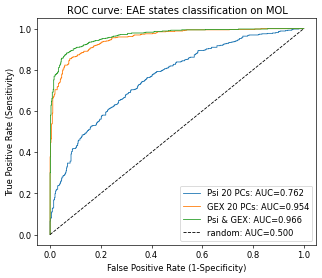

In [42]:
fig = plt.figure(figsize=(6, 5), dpi=60)
ROC_plot(Y1, Y1_score[:,1], label="Psi 20 PCs", base_line=False)
ROC_plot(Y1, Y2_score[:,1], label="GEX 20 PCs", base_line=False)
ROC_plot(Y1, Y3_score[:,1], label="Psi & GEX")

plt.title("ROC curve: EAE states classification on MOL")

# fig.savefig(dat_dir + '../../figures/fig_s9_EAE_predict.pdf', dpi=300, bbox_inches='tight')
plt.show()

### Techinical diagnosis

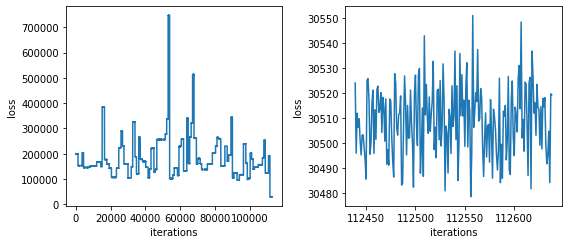

In [43]:
## There are multiple batches in running jobs, so you will steps; 
## the second part shows the last bit of the final batch

brie.pl.loss(adata.uns['brie_losses'])